In [1]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model import lstm_unet
import keras.backend as K
from helpers import f1
import warnings
import numpy as np
from data_loader import DataGenerator
warnings.filterwarnings("ignore")

2025-07-22 18:23:13.752050: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-22 18:23:13.788487: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-22 18:23:13.788526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-22 18:23:13.789865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-22 18:23:13.796870: I tensorflow/core/platform/cpu_feature_guar

In [2]:
model = lstm_unet(256, 256, 3, 15)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])
model.summary()

2025-07-22 18:23:15.578714: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-07-22 18:23:15.578744: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: a6fac06d5a7e
2025-07-22 18:23:15.578751: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: a6fac06d5a7e
2025-07-22 18:23:15.578814: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.144.3
2025-07-22 18:23:15.578836: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.144.3
2025-07-22 18:23:15.578842: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 550.144.3


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 15, 256, 256, 3)]    0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 15, 256, 256, 16)     448       ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 15, 256, 256, 16)     0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                                              

In [3]:
train_gen = DataGenerator(
    image_dir="data_v3_processed/train/images/images",
    mask_dir="data_v3_processed/train/masks/masks",
    batch_size=12,
    time_steps=15,
    img_size=(256,256),
    normalize_images=True,
    normalize_masks=False,
)

In [4]:
val_gen = DataGenerator(
    image_dir="data_v3_processed/val/images/images",
    mask_dir="data_v3_processed/val/masks/masks",
    batch_size=12,
    time_steps=15,
    img_size=(256,256),
    normalize_images=True,
    normalize_masks=False,
)

In [5]:
steps_per_epoch = len(train_gen.samples) // train_gen.batch_size
validation_steps = len(val_gen.samples) // val_gen.batch_size

In [6]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    batch_size=6,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
18/18 [==============================] - 21s 858ms/step - loss: 0.3054 - f1: 0.0035 - val_loss: 0.1073 - val_f1: 0.0000e+00
Epoch 2/20
18/18 [==============================] - 15s 825ms/step - loss: 0.0788 - f1: 0.0000e+00 - val_loss: 0.1020 - val_f1: 0.0000e+00
Epoch 3/20
18/18 [==============================] - 14s 769ms/step - loss: 0.0646 - f1: 0.0000e+00 - val_loss: 0.0765 - val_f1: 0.0000e+00
Epoch 4/20
18/18 [==============================] - 14s 757ms/step - loss: 0.0585 - f1: 0.0000e+00 - val_loss: 0.0769 - val_f1: 0.0000e+00
Epoch 5/20
18/18 [==============================] - 14s 744ms/step - loss: 0.0566 - f1: 0.0000e+00 - val_loss: 0.0752 - val_f1: 0.0000e+00
Epoch 6/20
18/18 [==============================] - 14s 741ms/step - loss: 0.0559 - f1: 0.0000e+00 - val_loss: 0.0718 - val_f1: 0.0000e+00
Epoch 7/20
18/18 [==============================] - 14s 757ms/step - loss: 0.0553 - f1: 0.0000e+00 - val_loss: 0.0702 - val_f1: 0.0000e+00
Epoch 8/20
18/18 [=============

In [7]:
import cv2
import numpy as np

time_steps = 15
img_size = (256, 256)

# Load and preprocess single image
img = cv2.imread('data_v3_processed/test/images/images/28_05_08_11.png')
img = img.astype(np.float32) / 255.0

# Create a sequence by repeating the image
sequence = np.stack([img] * time_steps, axis=0)  # shape (time_steps, H, W, C)

# Add batch dimension
input_seq = np.expand_dims(sequence, axis=0)  # shape (1, time_steps, H, W, C)

pred = model.predict(input_seq)

1/1 [==============================] - 1s 520ms/step


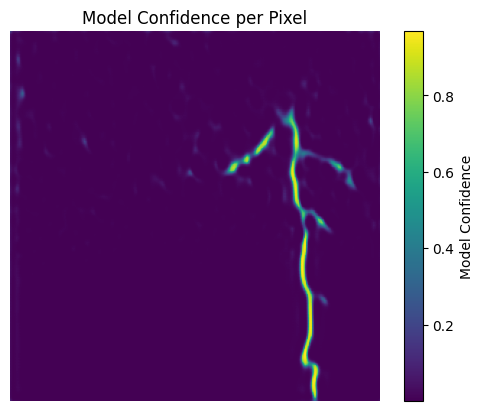

In [8]:
import matplotlib.pyplot as plt

confidence_map = pred[0, :, :, 0]  # Remove batch and channel dims

plt.imshow(confidence_map, cmap='viridis')  # or 'plasma', 'hot', etc.
plt.colorbar(label="Model Confidence")
plt.title("Model Confidence per Pixel")
plt.axis('off')
plt.show()

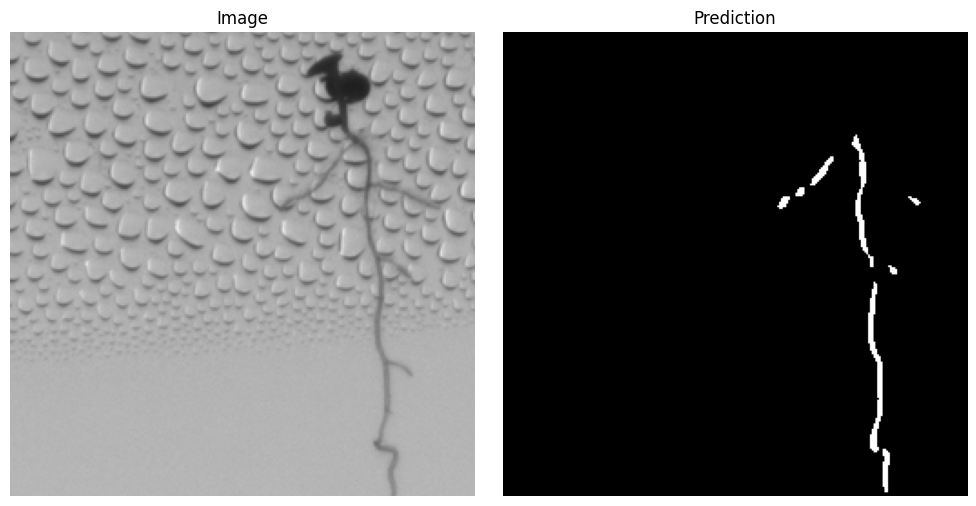

In [9]:
pred = (pred > 0.5).astype(np.uint8)

pred_img = np.squeeze(pred, axis=0)
pred_vis = (pred_img * 255).astype(np.uint8)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # width x height in inches

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image')
plt.axis('off')

# Prediction
plt.subplot(1, 2, 2)
plt.imshow(pred_vis, cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
#model.save("lstm_unet_model.h5")